Authors: Luka Grubišić, Marko Hajba, Domagoj Lacmanović


---

We are solving the time-independent Schrödinger equation in one dimension using the Variational Physical Informed Neural Network (VPINN).
$$\begin{equation}
-\triangle u+V_\omega u~ =\varepsilon u .
\end{equation}$$

---

Potential $V$ is generated as linear combination of the finite well and two inverted Gaussians, 
$$V=-\alpha_1 \exp(-\|\cdot-c_1\|)^2/k_1^2)-\alpha_2 \exp(-\|\cdot-c_2\|)^2/k_2^2)-h\boldsymbol 1_{\{x:~|x-c| < t\}}.
$$
We use $\boldsymbol 1_{\{x:~|x-c| < t\}}$ to denote the indicator function and choose $\alpha_i\in[8,12]$, $c_i\in[-2.5,2.5]$, $k_i\in[0.9,2.6]$, $i=1,2$, $h\in[10,15]$, $c\in[-2,2]$ , $t\in[0.5,2.5]$.

---

Loss function used: $$L(u;\beta,\eta)=\dfrac{\int_{\Omega}|\nabla u|^2+\int_{\Omega}V_{\omega}u^2}{\int_{\Omega}u}+\beta(u^2(B)+u^2(-B))+\eta\left(\int_{\Omega}u^2-1\right),$$

---

To compute the residuals and the energy of the modes we use a Gaussian quadrature where the deep network is evaluated at the sufficient number -- for the given interval $(-B,B)$ -- of Gaussian points. In this example we used 1024 quadrature points on an interval  $(-6,6)$.

A-posteriori (residual) error estimator
$$
\Delta_\varepsilon^2=\|H \psi-\varepsilon\psi\|^2/(\varepsilon^2\|\psi\|^2)~
$$
is used to monitor performance of the training of the VPINN and it is good stopping criteria. For full algorithm and more details you can read the paper.

Let us also emphasize that $\Delta_\varepsilon$ measures the distance of the Rayleigh Quotient (energy functional) to the nearest eigenvalue. This algorithm can be used in higher dimensional space, but different quadrature rules should be used.

---

To benchmark the accuracy of the VPINN approximations we have solved the problem to high relative accuracy using the Chebyshev spectral method as implemented in the package $\texttt{chebfun}$. We emphasize that \texttt{chebfun} was not used during the training of the network in any way. We use a neural network architecture similar to the DenseNet concept. Activation function $\rho(x)=\exp(-x^2/10)$ is used to enforce positivity of the solution. 



In [ ]:
# load important packages
import os
import tensorflow as tf
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensorflow.keras import layers
from datetime import datetime
tf.random.set_seed(1)
import random
random.seed(1)
np.random.seed(1)

from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras import losses
import scipy
from scipy import integrate
import time
from scipy.interpolate import CubicSpline

global nx
nx = 1024

a = -6
b = 6
# generate Gaussian quadrature points on [-1, 1]
[x1, w] = tf.constant(scipy.special.roots_legendre(nx))

####### Gaussian quadrature points on [a, b]
x = 0.5*(x1 + 1)*(b - a) + a
# gauss = sum(w * f(t)) * 0.5*(b - a)
x = tf.reshape(x, [nx,] )
w = tf.reshape(w, [nx,] )
x = tf.cast(x, dtype='float32')
w = tf.cast(w, dtype='float32')


2.4.0


In [ ]:
## load data from chebfun
import scipy as scipy
import scipy.io as sio

#######################
mat = sio.loadmat('ground_state_1D_data.mat')
U0_comb_d = mat['U0_comb']
EV_comb = mat['EV_comb']
EV_comb = EV_comb[:, 0]
A1_comb = mat['A1_comb']
A2_comb = mat['A2_comb']
c1_comb = mat['c1_comb']
c2_comb = mat['c2_comb']
cfw_comb = mat['cfw_comb']
h_comb = mat['h_comb']
k1_comb = mat['k1_comb']
k2_comb = mat['k2_comb']
t_comb = mat['t_comb']

## test shapes
nodes = len(U0_comb_d[0])
x_d = mat['x_d'].reshape(nodes,)
x_d = tf.cast(x_d, dtype = 'float32')
x_d = tf.reshape(x_d, [len(x_d),] )

In [ ]:
## define potentials
def V_comb(xi):
    return -tf.constant( A1_comb * np.exp(-((xi-c1_comb)/k1_comb)**2) + \
                         A2_comb * np.exp(-((xi-c2_comb)/k2_comb)**2) + \
                         h_comb * ( np.abs(xi - cfw_comb) < t_comb ), dtype = 'float32' )

In [ ]:
## define custom activation
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras import backend as K
def activ(x):
    return tf.keras.activations.exponential(-0.1*x*x)

In [ ]:
def NN(x):
    #init = tf.keras.initializers.RandomNormal(mean=0.0, stddev=4.0, seed=2)
    tf.random.set_seed(1)
    init1 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init2 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init3 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init4 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init5 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init6 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init7 = tf.keras.initializers.GlorotUniform(seed = 5)
    tf.random.set_seed(1)
    init8 = tf.keras.initializers.GlorotUniform(seed = 5)
    #activation=activ,tf.keras.activations.relu
    inputs = layers.Input(shape = (1, ), name = "inputs")
    h1 = layers.Dense(10, name = "h1", kernel_initializer=init1, bias_initializer=tf.keras.initializers.Zeros())(inputs)
    h1 = layers.Activation(activ)(h1)
    h2 = layers.Dense(10, name = "h2", kernel_initializer=init2, bias_initializer=tf.keras.initializers.Zeros())(h1)
    h2 = layers.Activation(activ)(h2)
    c1 = layers.Concatenate()([inputs, h2])
    
    h3 = layers.Dense(10, name = "h3", kernel_initializer=init3, bias_initializer=tf.keras.initializers.Zeros())(c1)
    h3 = layers.Activation(activ)(h3)
    h4 = layers.Dense(10, name = "h4", kernel_initializer=init4, bias_initializer=tf.keras.initializers.Zeros())(h3)
    h4 = layers.Activation(activ)(h4)
    c2 = layers.Concatenate()([c1, h4])
    
    
    h5 = layers.Dense(10, name = "h5", kernel_initializer=init5, bias_initializer=tf.keras.initializers.Zeros())(c2)
    h5 = layers.Activation(activ)(h5)
    h6 = layers.Dense(10, name = "h6", kernel_initializer=init6, bias_initializer=tf.keras.initializers.Zeros())(h5)
    h6 = layers.Activation(activ)(h6)
    c3 = layers.Concatenate()([c2, h6])
   
    h7 = layers.Dense(10, name = "h7", kernel_initializer=init7, bias_initializer=tf.keras.initializers.Zeros())(c3)
    h7 = layers.Activation(activ)(h7)
    h8 = layers.Dense(10, name = "h8", kernel_initializer=init8, bias_initializer=tf.keras.initializers.Zeros())(h7)
    h8 = layers.Activation(activ)(h8)
    c4 = layers.Concatenate()([c3, h8])
    
    out0 = layers.Dense(1, name = "out", kernel_initializer=init7, bias_initializer=tf.keras.initializers.Zeros())(c4)
    out = layers.Activation(activ)(out0)
    # define model
    model = tf.keras.Model(inputs, out)
    # define optimizer
    return model

# check model arhitecture
model = NN(x)
model.summary()
optim = tf.keras.optimizers.Adam(lr=0.001)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
h1 (Dense)                      (None, 10)           20          inputs[0][0]                     
__________________________________________________________________________________________________
activation_9 (Activation)       (None, 10)           0           h1[0][0]                         
__________________________________________________________________________________________________
h2 (Dense)                      (None, 10)           110         activation_9[0][0]               
____________________________________________________________________________________________

In [ ]:
## A-posteriori (residual) error estimator
def residual2(x, w, V_d, model):
  def residual_scaled(y_true, y_pred):
    with tf.GradientTape() as g:
        g.watch(x)
        with tf.GradientTape() as gg:
            gg.watch(x)
            pred = model(x)
        grad = gg.gradient(pred, x)     # Will compute first derivative
    grad2 = g.gradient(grad, x)          # Will compute second derivative
    y_pred = model(x)
    y_pred = tf.reshape(y_pred, (len(x), ))

    grad = tf.cast(grad, dtype = 'float32')
    grad = tf.reshape(grad, [nx,] )
    grad2 = tf.reshape(grad2, [nx,] )
    
    Ham = -grad2 + tf.multiply(V_d, y_pred)
    Ham = tf.reshape(Ham, [nx,] )
    
    y_pred_sq = tf.square(y_pred)
    pred_int_2 = tf.math.reduce_sum(tf.multiply(w, y_pred_sq)*(b-a)*0.5)
      
    e = tf.math.reduce_sum(tf.multiply(w, tf.multiply(Ham, y_pred))*(b-a)*0.5)/pred_int_2
    
    eq_res = tf.math.reduce_sum(tf.multiply(w, tf.square(Ham - e*y_pred ))*(b-a)*0.5)/ tf.multiply(tf.math.abs(e*e), pred_int_2)

    return eq_res
  return residual_scaled

In [ ]:
## Metrics: relative error of the ground state energy in strong sense
def ritz_strong(x, w, V_d, EV, model):
  def ritz_s(y_true, y_pred):
    with tf.GradientTape() as g:
        g.watch(x)
        with tf.GradientTape() as gg:
            gg.watch(x)
            pred = model(x)
        grad = gg.gradient(pred, x)     # compute first derivative
    grad2 = g.gradient(grad, x)          # compute second derivative
    y_pred = model(x)
    y_pred = tf.reshape(y_pred, (len(x), ))

    grad = tf.cast(grad, dtype = 'float32')
    grad = tf.reshape(grad, [nx,] )
    grad2 = tf.reshape(grad2, [nx,] )
    
    Ham = -grad2 + tf.multiply(V_d, y_pred)
    Ham = tf.reshape(Ham, [nx,] )
    
    y_pred_sq = tf.square(y_pred)
    pred_int_2 = tf.math.reduce_sum(tf.multiply(w, y_pred_sq)*(b-a)*0.5)

    e = tf.math.reduce_sum(tf.multiply(w, tf.multiply(Ham, y_pred))*(b-a)*0.5)/pred_int_2
    
    ritz_res_strong = tf.math.abs((EV-e)/e)
    
    return ritz_res_strong
  return ritz_s

In [ ]:
## Metrics: relative error of the ground state energy in weak (variational) sense
def ritz_weak(x,w, V_d, EV, model):
  def ritz_w(y_true, y_pred):
    dbc = tf.constant([6], dtype='float32')
    with tf.GradientTape() as g:
        g.watch(x)
        pred = model(x) #, training = True)
    grad = g.gradient(pred, x)     # Will compute first derivative
    y_pred = model(x)
    y_pred = tf.reshape(y_pred, (len(x), ))

    grad = tf.cast(grad, dtype = 'float32')
    grad = tf.reshape(grad, [nx,] )
    
    y_pred_sq = tf.square(y_pred)
    pred_int_2 = tf.math.reduce_sum(tf.multiply(w, y_pred_sq)*(b-a)*0.5)
    
    e = tf.math.reduce_sum(tf.multiply(w, tf.square(grad))*(b-a)*0.5)
    e = e + tf.math.reduce_sum(tf.multiply(w, tf.multiply(V_d, y_pred_sq))*(b-a)*0.5)
    e = e / pred_int_2
    
    ritz_res_weak = tf.math.abs((EV-e)/e)
    
    return ritz_res_weak
  return ritz_w

In [ ]:
## Loss function:
def get_loss(x,w, V_d, model, lbc, rbc, beta, eta):
  def loss(y_true, y_pred):
    dbc = tf.constant([6], dtype='float32')
    with tf.GradientTape() as g:
        g.watch(x)
        pred = model(x) #, training = True)
    grad = g.gradient(pred, x)     # Will compute first derivative
    y_pred = model(x)
    y_pred = tf.reshape(y_pred, (len(x), ))

    grad = tf.cast(grad, dtype = 'float32')
    grad = tf.reshape(grad, [nx,] )
    
    y_pred_sq = tf.square(y_pred)
    pred_int_2 = tf.math.reduce_sum(tf.multiply(w, y_pred_sq)*(b-a)*0.5)
        
    loss_value = tf.math.reduce_sum(tf.multiply(w, tf.square(grad))*(b-a)*0.5)
    loss_value = loss_value + tf.math.reduce_sum(tf.multiply(w, tf.multiply(V_d, y_pred_sq))*(b-a)*0.5)
    loss_value = loss_value / pred_int_2
    ## add penalization to enforce boundary conditions of the ground-state, parametar $\eta$
    loss_value = loss_value  + beta * ( tf.square(model(lbc)) + tf.square(model(rbc)) )
    ## add penalization to enforce normalization of the ground-state, parametar $\eta$
    loss_value = loss_value + eta * tf.math.square(tf.math.reduce_sum(tf.multiply(w, y_pred_sq)*(b-a)*0.5) - 1)

    return loss_value
  return loss

In [ ]:
## choose the example
V_d = tf.reshape(V_comb(x), (len(x),))
energy = EV_comb
U0d = U0_comb_d
lbc = tf.constant([a], dtype='float32')
rbc = tf.constant([b], dtype='float32')
beta = 0.00001
eta = 20

## compile model with chosen lr and metrics to monitor
model = NN(x)
optim = tf.keras.optimizers.Adam(lr=0.001)

## Loss function is get_loss(x,w, V_d, model, lbc, rbc, beta, eta)
var_loss = get_loss(x, w, V_d, model, lbc, rbc, beta, eta)
eq_res_2 = residual2(x, w, V_d, model)
ritz_res_strong = ritz_strong(x, w, V_d, energy, model)
ritz_res_weak = ritz_weak(x, w, V_d, energy, model)
model.compile( loss = var_loss,
  optimizer=optim, metrics = [eq_res_2, ritz_res_strong, ritz_res_weak])

In [ ]:
## train the model
## callback can be used to monitor $\Delta_\epsilon^2$ and stop training if error estimator is small enough, 
#  otherwise we can continue training for additional epochs or change the arhitecture of the neural network
no_epoch = 15000

history = model.fit(x, model(x),
      verbose = 0,
      batch_size = len(x),
      epochs = no_epoch,
      #callbacks = [callback]
      )


([<matplotlib.axis.XTick at 0x7f06c980be10>,
 [Text(0, 0, '0'),
  Text(0, 0, '5,000'),
  Text(0, 0, '10,000'),
  Text(0, 0, '15,000')])

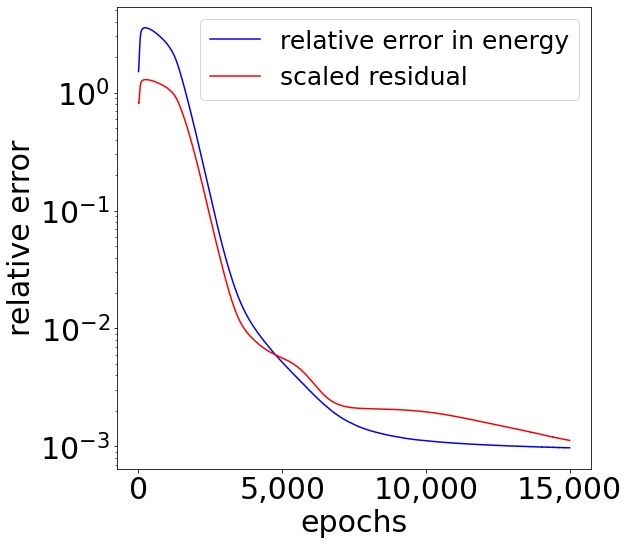

In [ ]:
## plot relative error in the ground state energy and scaled residual $\Delta_\epsilon^2$

plt.figure(figsize=(8.5, 8.5))
plt.semilogy(history.history['ritz_s'], 'b', label = 'relative error in energy')
plt.semilogy(history.history['residual_scaled'], 'r', label = 'scaled residual')

plt.legend(fontsize=25)
#plt.xticks([0, 5000, 10000, 15000], fontsize=30)
plt.yticks(fontsize=30)
plt.xlabel('epochs', fontsize=30)
plt.ylabel('relative error', fontsize=30)
#plt.get_xaxis().set_major_formatter(lambda x, p:format(int(x), ','))
#plt.yaxis.set_major_formatter(plt.ticker.StrMethodFormatter('{x:,.0f}'))
xticks_d = [0, 5000, 10000, 15000]
xlabels = [f'{label:,}' for label in xticks_d]
plt.xticks(xticks_d, xlabels, fontsize=30)

In [ ]:
## analyse ground state and ground state energy accuracy
pred_data = model(x)
NN_d = tf.reshape(pred_data, (len(x), ))
with tf.GradientTape() as g:
    g.watch(x)
    pred = model(x)
grad = g.gradient(pred, x)     # Will compute f

e0_NN = tf.math.reduce_sum(tf.multiply(w, tf.square(grad))*(b-a)*0.5)
e0_NN = e0_NN + tf.math.reduce_sum(tf.multiply(w, tf.multiply(V_d, tf.square(NN_d)))*(b-a)*0.5)
e0_NN = e0_NN / tf.math.reduce_sum(tf.multiply(w, tf.square(NN_d))*(b-a)*0.5)

e0_cheb = energy

rel_err_e0 = tf.math.abs((e0_cheb.astype('float32') - e0_NN)/e0_NN)*100

print('e0 from Chebfun:', e0_cheb)
print('e0 from NN:', e0_NN)
print('Last loss value', history.history['loss'][no_epoch-1])
print('Relative error in energy:', (tf.math.abs(e0_cheb.astype('float32') - e0_NN)/(tf.math.abs(e0_cheb.astype('float32'))))*100, '%')
print('Relative error in energy from metrics:',history.history['ritz_w'][no_epoch-1]*100, '%' )
print('L2 norm of NN solution', tf.math.sqrt(tf.math.reduce_sum(tf.multiply(w, tf.square(NN_d))*(b-a)*0.5)))


e0 from Chebfun: [-29.50508829]
e0 from NN: tf.Tensor(-29.476435, shape=(), dtype=float32)
Last loss value -29.476428985595703
Relative error in energy: tf.Tensor([0.09711578], shape=(1,), dtype=float32) %
Relative error in energy from metrics: 0.09721019305288792 %
L2 norm of NN solution tf.Tensor(0.99979925, shape=(), dtype=float32)


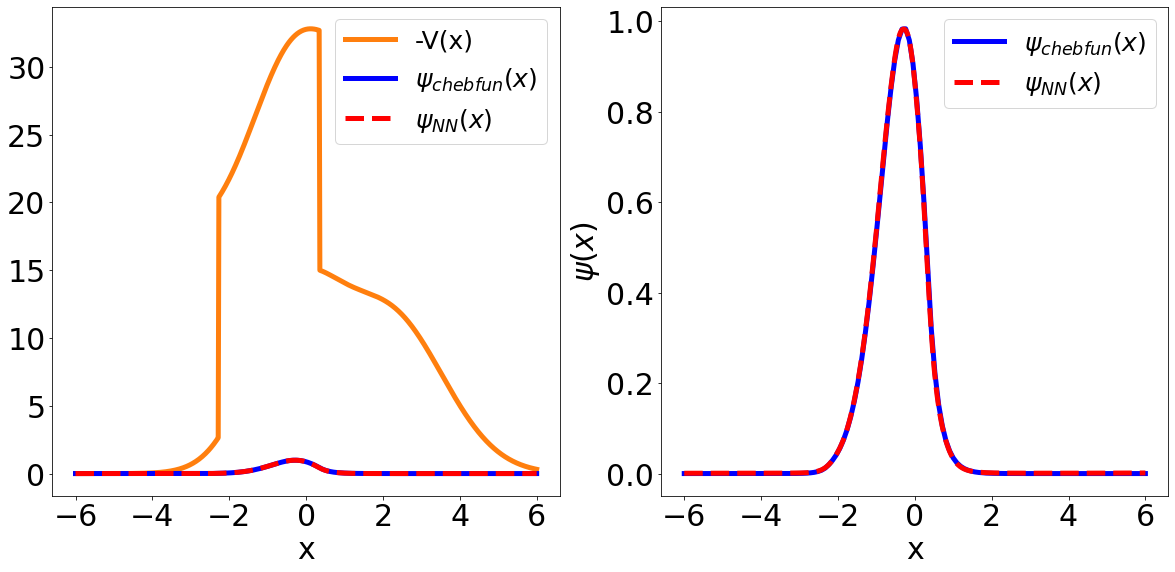

In [ ]:
## plot solutions
U0d = tf.cast(U0d, dtype = 'float32')
U0d = tf.reshape(U0d, [nodes,1] )

plt.figure(figsize=(20, 9))
ax = plt.subplot(1,2, 1)
plt.plot(x, -V_d, 'tab:orange', linewidth=5, label='-V(x)')
plt.plot(x_d, U0d, 'b', linewidth=5, label='$\psi_{chebfun}(x)$')
pred_data = model(x)
NN_d = tf.reshape(np.abs(pred_data), (len(x), ))
plt.plot(x, NN_d, 'r--',  linewidth=5, label='$\psi_{NN}(x)$')

plt.legend(fontsize = 25, loc = 1)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel('x', fontsize = 30)

ax = plt.subplot(1,2, 2)
plt.plot(x_d, U0d, 'b', linewidth=5, label='$\psi_{chebfun}(x)$')
pred_data = model(x)
NN_d = tf.reshape(np.abs(pred_data), (len(x), ))
plt.plot(x, NN_d, 'r--',  linewidth=5, label='$\psi_{NN}(x)$')

plt.legend(fontsize = 25, loc = 1)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel('x', fontsize = 30)
plt.ylabel('$\psi(x)$', fontsize = 30)
plt.show()

In [ ]:
#######################
## Additional testing #
#######################

nt = 4096

a = -6
b = 6
# generate Gaussian quadrature points on [-1, 1]
[x1, wt] = tf.constant(scipy.special.roots_legendre(nt))

####### Gaussian quadrature points on [a, b]
xt = 0.5*(x1 + 1)*(b - a) + a
# gauss = sum(w * f(t)) * 0.5*(b - a)
xt = tf.reshape(xt, [nt,] )
wt = tf.reshape(wt, [nt,] )
xt = tf.cast(xt, dtype='float32')
wt = tf.cast(wt, dtype='float32')

In [ ]:
V_t = V_comb(xt)

pred_t = model(xt)
NN_dt = tf.reshape(pred_t, (len(xt), ))
with tf.GradientTape() as g:
    g.watch(xt)
    predt = model(xt) #, training = True)
gradt = g.gradient(predt, xt)     # Will compute f

e0_NN = tf.math.reduce_sum(tf.multiply(wt, tf.square(gradt))*(b-a)*0.5)
e0_NN = e0_NN + tf.math.reduce_sum(tf.multiply(wt, tf.multiply(V_t, tf.square(NN_dt)))*(b-a)*0.5)
e0_NN = e0_NN / tf.math.reduce_sum(tf.multiply(wt, tf.square(NN_dt))*(b-a)*0.5)

e0_cheb =energy

rel_err_e0 = tf.math.abs((e0_cheb.astype('float32') - e0_NN)/e0_NN)*100

print('e0 from Chebfun:', e0_cheb)
print('e0 from NN:', e0_NN)
print('Last loss value', history.history['loss'][no_epoch-1])
print('Relative error in energy:', (tf.math.abs(e0_cheb.astype('float32') - e0_NN)/(tf.math.abs(e0_cheb.astype('float32'))))*100, '%')
print('L2 norm of NN solution', tf.math.sqrt(tf.math.reduce_sum(tf.multiply(wt, tf.square(NN_dt))*(b-a)*0.5)))

e0 from Chebfun: [-29.50508829]
e0 from NN: tf.Tensor(-29.504408, shape=(), dtype=float32)
Last loss value -29.476428985595703
Relative error in energy: tf.Tensor([0.00230782], shape=(1,), dtype=float32) %
L2 norm of NN solution tf.Tensor(0.9998122, shape=(), dtype=float32)


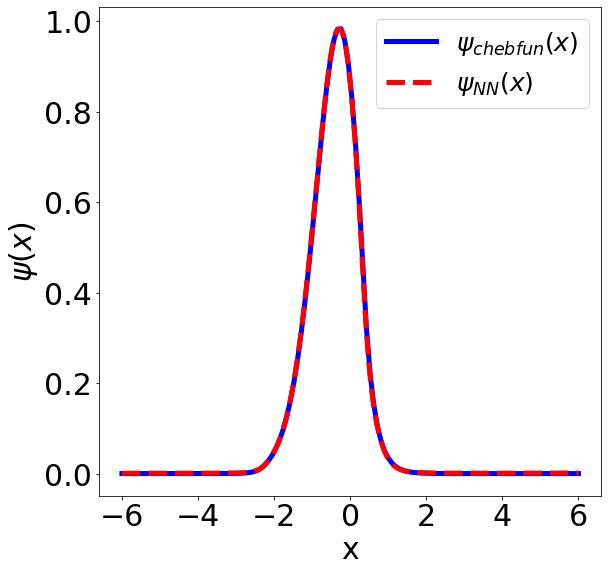

In [ ]:
## plot
plt.figure(figsize=(9, 9))
plt.plot(x_d, np.reshape(U0_comb_d, (len(x_d),)), 'b', linewidth=5, label='$\psi_{chebfun}(x)$')
plt.plot(xt, NN_dt, 'r--',  linewidth=5, label='$\psi_{NN}(x)$')
plt.legend(fontsize = 25, loc = 1)
plt.xticks(fontsize = 30)
plt.yticks(fontsize = 30)
plt.xlabel('x', fontsize = 30)
plt.ylabel('$\psi(x)$', fontsize = 30)
plt.show()